In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

import plotly.io as pio
pio.renderers.default = "png"

from functions import missing_data_df, impute_null, modify_features, encode_ordinal, dummify_features

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Loading the data

In [2]:
# Load the data
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)
df.rename(columns = {'1stFlrSF':'FlrSF1st', '2ndFlrSF':'FlrSF2nd'}, inplace = True)

df = df[df.SaleCondition == 'Normal']
df = df[~df.MSZoning.isin(['C (all)', 'I (all)', 'A (all)', 'A (agr)'])] # not residential

df shape: (2580, 80)


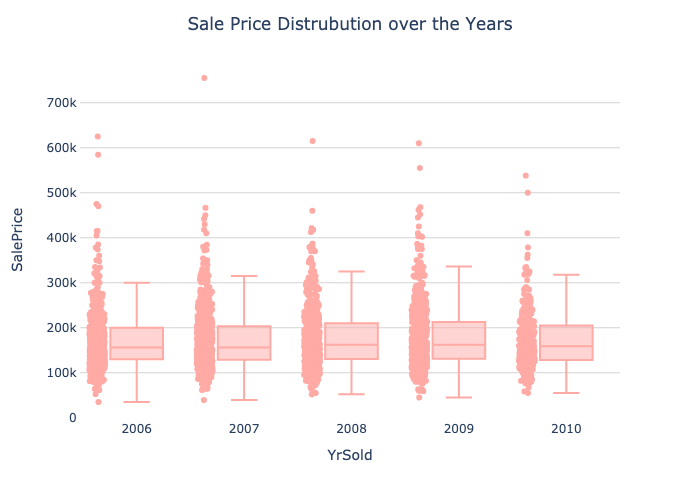

In [4]:
# Sale Price distribution for each year
fig = px.box(
            df, 
            x='YrSold', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(title='Sale Price Distrubution over the Years', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

# Add lag terms

In [5]:
# Save 2010 data for predicting
print(df.YrSold.value_counts(normalize=True))

# We'll perform EDA only on the training set so the test set can give us an unbiased estimate of the error. 
df_2010 = df[df['YrSold']==2010].reset_index(drop=True)
df = df[df['YrSold']<2010].reset_index(drop=True)

YrSold
2009    0.232694
2007    0.230192
2008    0.219766
2006    0.191827
2010    0.125521
Name: proportion, dtype: float64


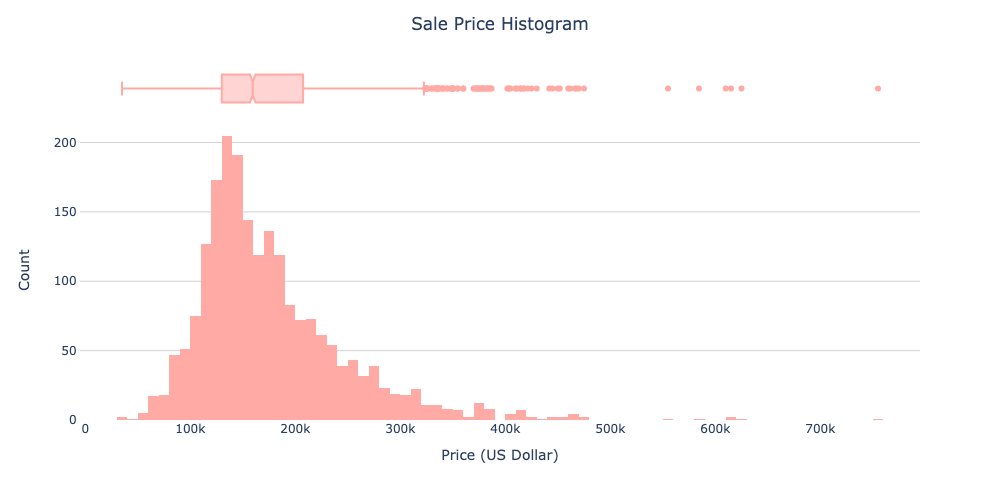

In [6]:
# We plot the target variable

fig = px.histogram(
                df, 
                x="SalePrice",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(
                title='Sale Price Histogram', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Price (US Dollar)",
                row=1, col=1)

fig.show()

## Missing data

In [7]:
# Check for missing values
missing_data_df(df)

,Count,Percent
PoolQC,2088,99.570815
MiscFeature,2022,96.423462
Alley,1961,93.514545
Fence,1664,79.351454
MasVnrType,1278,60.944206
FireplaceQu,988,47.114926
LotFrontage,403,19.217930
GarageYrBlt,93,4.434907
GarageFinish,93,4.434907
GarageQual,93,4.434907


In [8]:
# We will drop the PoolQC and PoolArea features since more that 99% of houses don't have a pool.
df.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

### Imputing null values

In [9]:
# LotFrontage

temp = df[~df['LotFrontage'].isna()]

print(temp.LotFrontage.describe())
temp.groupby(['LotConfig']).agg({'LotFrontage':['median', 'count']}).sort_values(by=('LotFrontage', 'median'))


count    1694.000000
mean       68.184179
std        22.671184
min        21.000000
25%        57.000000
50%        67.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


LotFrontage      
               median count
LotConfig                  
CulDSac          47.5    60
FR2              60.0    44
FR3              62.0     9
Inside           65.0  1315
Corner           80.0   266

We have different types of null values:
- On numerical variables where N/A means no feature we will impute with 0.
- On categorical variables where N/A means no feature we will impute with 'None'.
- The remaining features with N/A values will be imputed as followed:
    - For GarageYrBlt we'll useh YearBuilt.
    - For Electrical we'll use the mode.
    - For MasVnrType we'll impute with 'None'.
    - For MasVnrArea we'll impute with 0.
    - For LotFrontage we'll impute with the median given the LotConfig variable.

In [10]:
df = impute_null(df)
df_2010 = impute_null(df_2010)

## EDA

##### Numerical Features:

`['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']`

##### Discrete Features:

`['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                     'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSSubClass']`

##### Nominal Features:

`['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
                    'GarageType', 'SaleType']`

##### Ordinal Features:

`['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'OverallQual', 'OverallCond']`

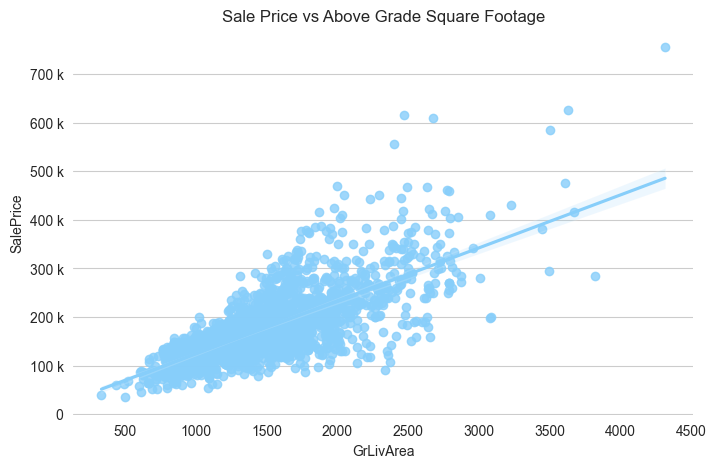

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine(left=True, bottom=True)

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax, color='#87CEFA') 
ax.set_title('Sale Price vs Above Grade Square Footage')
ax.xaxis.grid(False)

ax.yaxis.set_major_formatter(ticker.EngFormatter())

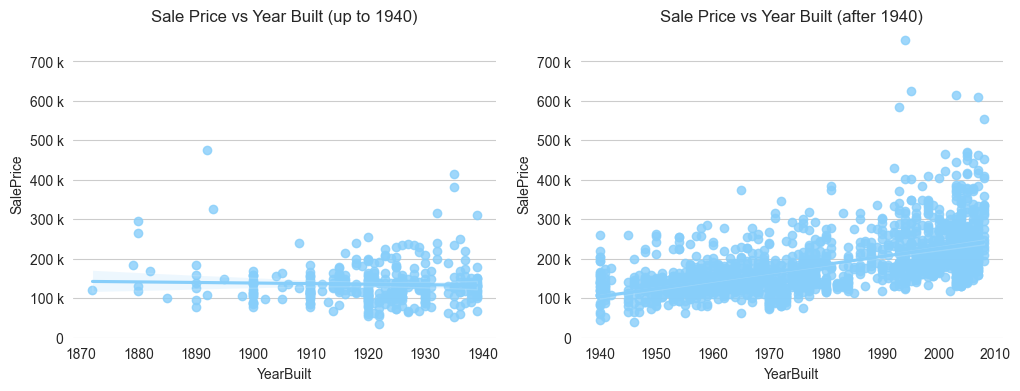

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)
YrCut=1940

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']<YrCut], ax=ax[0], color='#87CEFA') 

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']>=YrCut], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs Year Built (up to 1940)')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs Year Built (after 1940)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

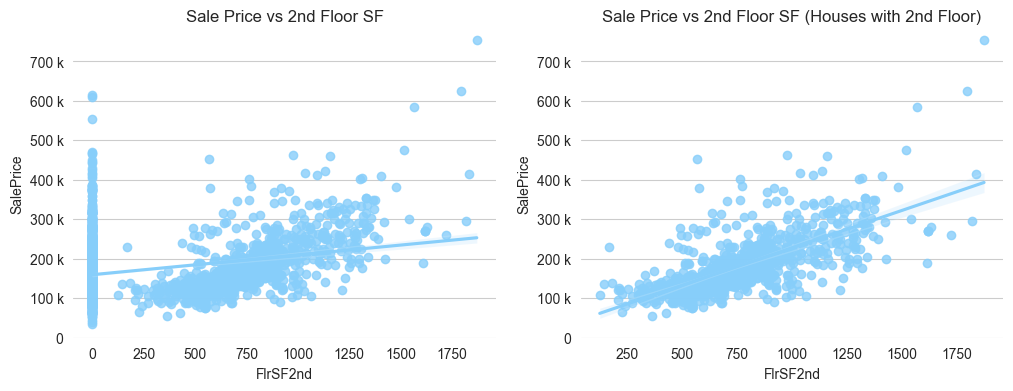

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

sns.regplot(x="FlrSF2nd", y="SalePrice", data=df, ax=ax[0], color='#87CEFA') 

sns.regplot(x="FlrSF2nd", y="SalePrice", data=df[df['FlrSF2nd']>0], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs 2nd Floor SF')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs 2nd Floor SF (Houses with 2nd Floor)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

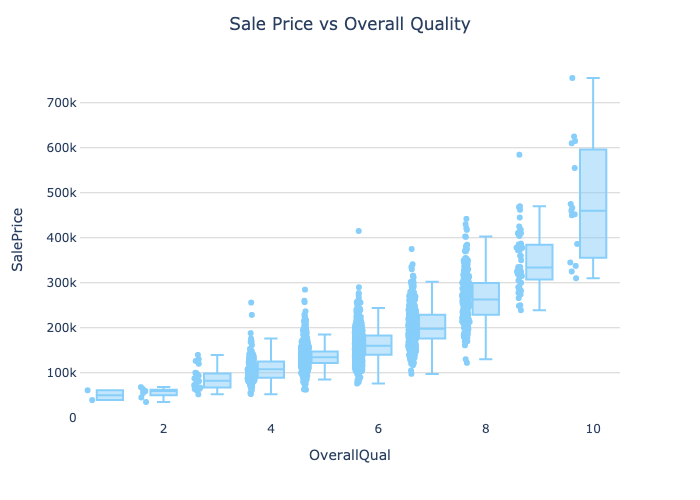

In [14]:
order = df.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='OverallQual', 
            y="SalePrice", 
            points="all",
            category_orders={'OverallQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs Overall Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

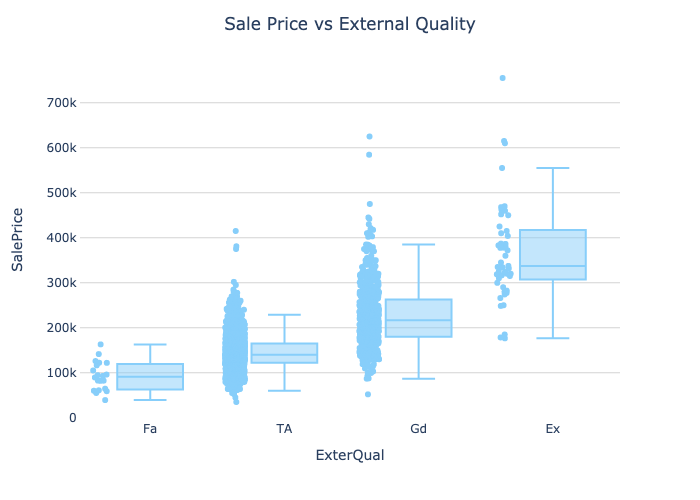

In [15]:
order = df.groupby('ExterQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='ExterQual', 
            y="SalePrice", 
            points="all",
            category_orders={'ExterQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

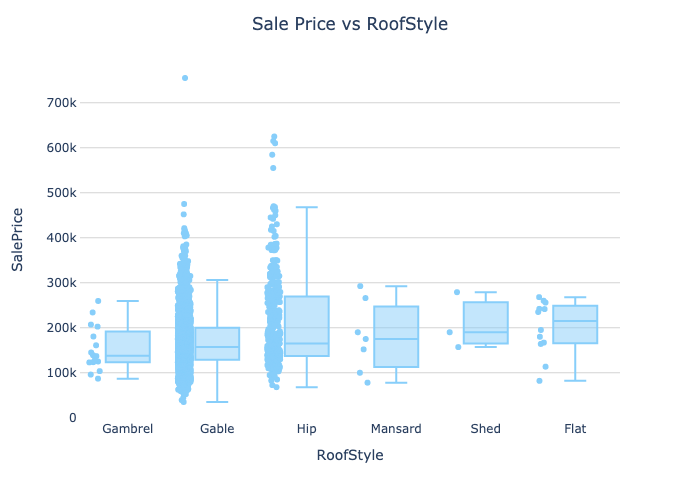

In [16]:
# Sale Price distribution for each year
order = df.groupby('RoofStyle').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='RoofStyle', 
            y="SalePrice", 
            points="all",
            category_orders={'RoofStyle':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs RoofStyle', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

## Feature Engineering

In [17]:
# Create HouseAge and RemodAge feature.
# Merge underpopulated categories
# Binarize features where only a few categories appear to be correlated to SalesPrice.
# Create a Location features
df = modify_features(df)
df_2010 = modify_features(df_2010)

In [18]:
# Encode ordinal features into numbers. 
df = encode_ordinal(df)
df_2010 = encode_ordinal(df_2010)

In [19]:
# Dummies Location and BldgType features
df = dummify_features(df)
df_2010 = dummify_features(df_2010)


### Check for interaction terms

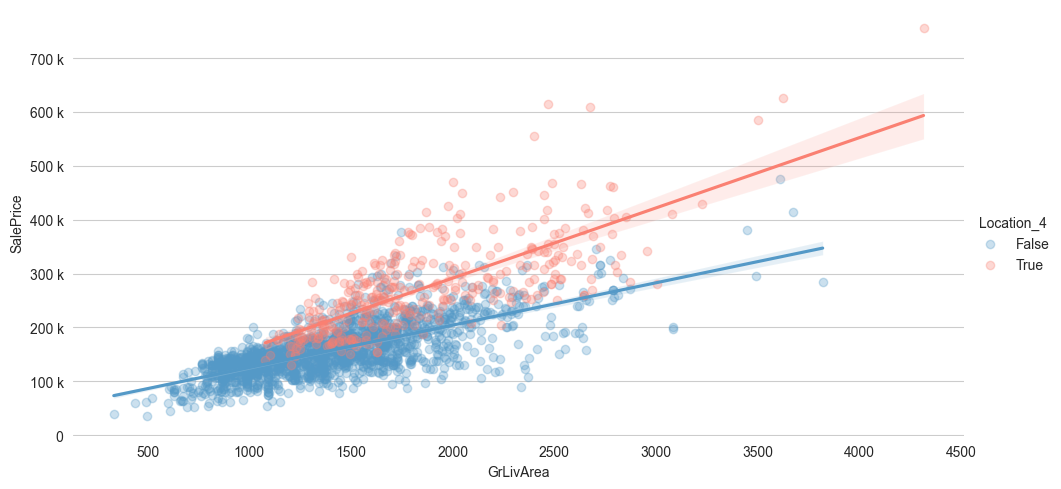

In [20]:
palette = {
    '#FA8072',
    '#5499C7'
}

g = sns.lmplot(
            x="GrLivArea", 
            y="SalePrice", 
            data=df, 
            hue='Location_4', 
            aspect=2,
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

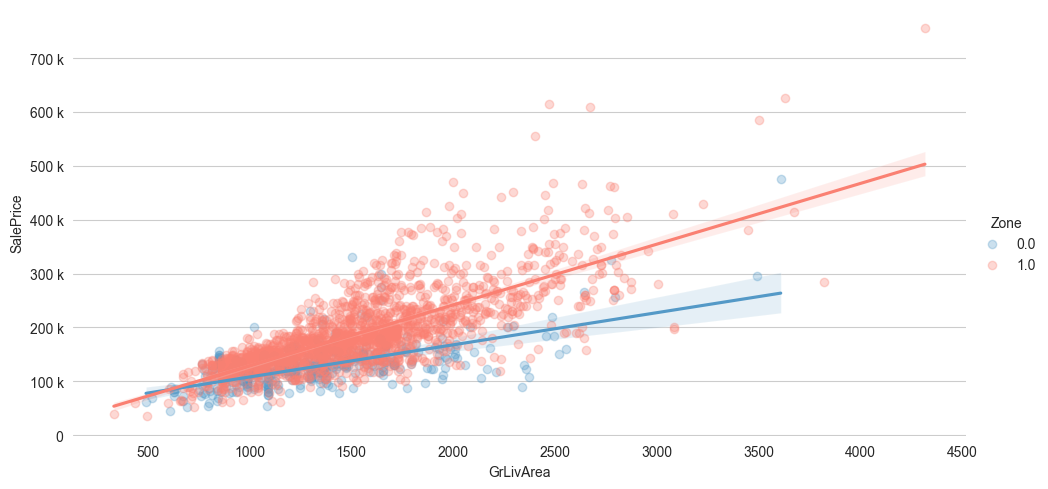

In [21]:
g = sns.lmplot(
            x="GrLivArea", 
            y="SalePrice", 
            data=df, 
            hue='Zone', 
            aspect=2, 
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

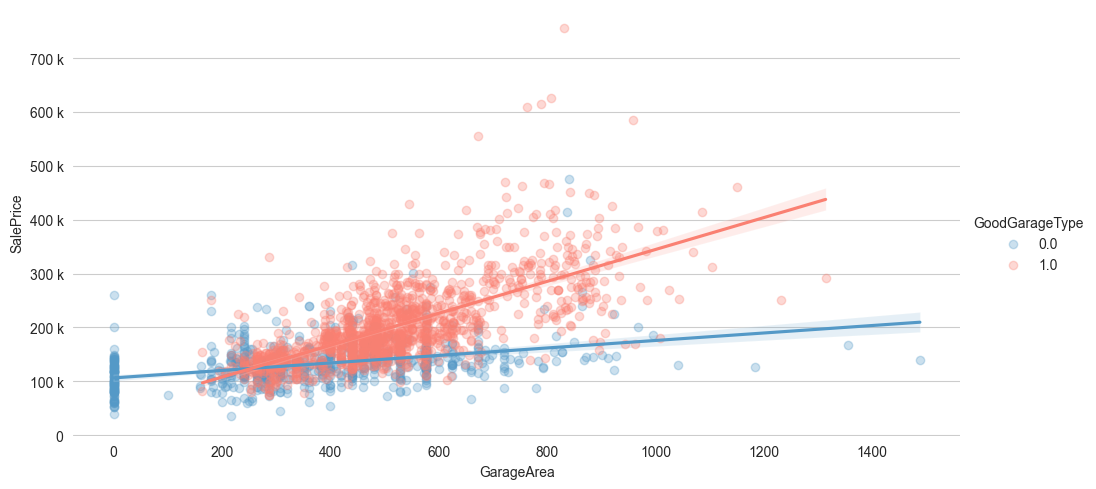

In [22]:
g = sns.lmplot(
            x="GarageArea", 
            y="SalePrice", 
            data=df, 
            hue='GoodGarageType', 
            aspect=2, 
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [23]:
df.GoodGarageType.value_counts()

GoodGarageType
1.0    1368
0.0     729
Name: count, dtype: int64

# Feature Selection

In [24]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', 'FlrSF1st', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', 'FlrSF2nd', 'OverallCond', 
                    'Fireplaces', 'LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location_2', 'Location_3', 'Location_4',
                    'CulDSac', 'Exterior1st_top']
                        

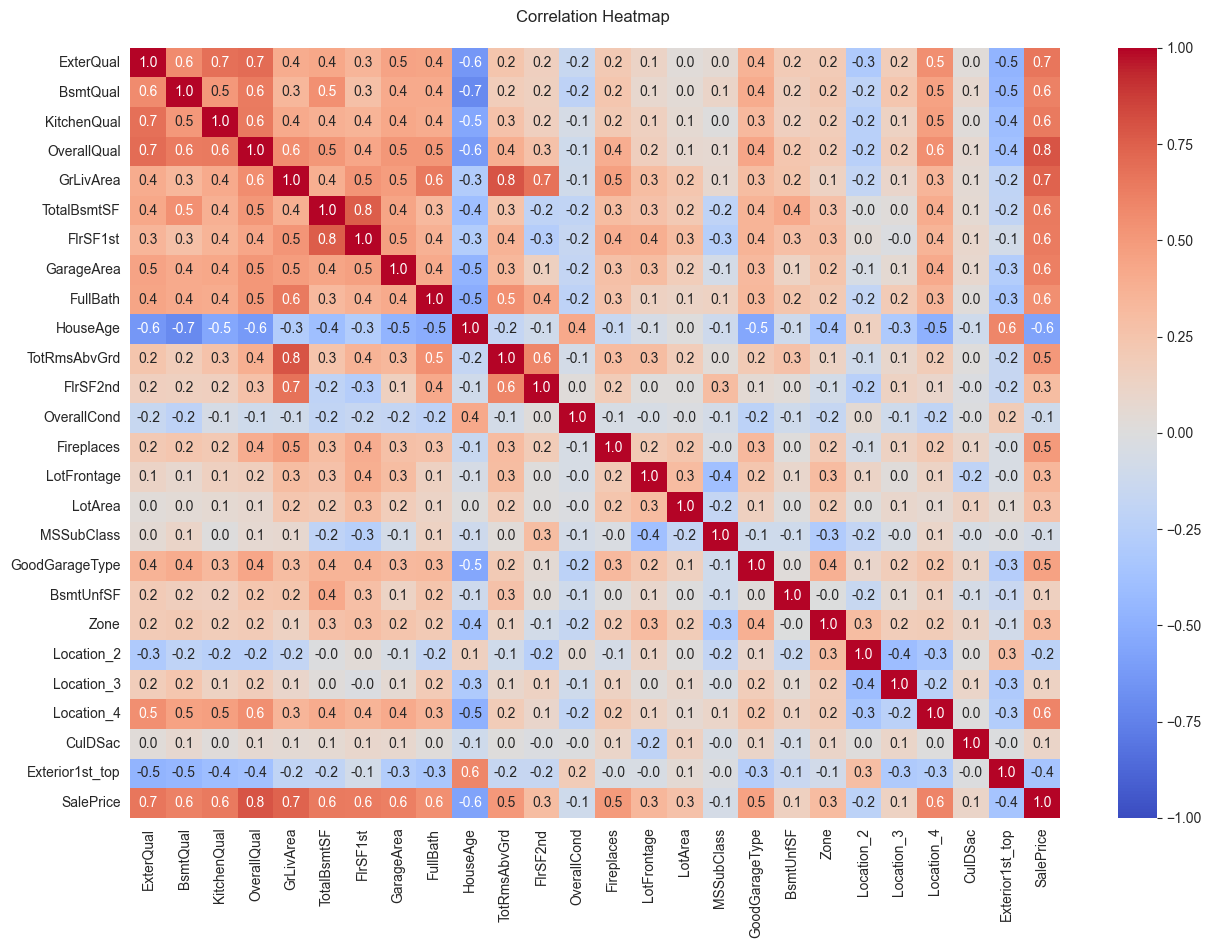

In [25]:
plt.figure(figsize=(15, 10))

corr_mat = df[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')